In [1]:
import time
import random
import sys
from ast import literal_eval

from utils.gamehelper import Poe2Bot, Entity
from utils.combat import AutoFlasks

In [2]:
notebook_dev = False
# readability
poe_bot_class = Poe2Bot
poe_bot: poe_bot_class

In [3]:
default_config = {
  "REMOTE_IP": '172.29.137.117', # z2
  "unique_id": "poe_2_test",
  "password": None,
  "force_reset_temp": False,
}



try:
  i = sys.argv[1]
  print(i)
  parsed_config = literal_eval(i)
  print(f'successfully parsed cli config')
  print(f'parsed_config: {parsed_config}')
except:
  print(f'cannot parse config from cli, using default\dev one')
  notebook_dev = True
  parsed_config = default_config
  parsed_config['unique_id'] = poe_bot_class.getDevKey()

config = {

}

for key in default_config.keys():
  config[key] = parsed_config.get(key, default_config[key])

print(f'config to run {config}')

--f=c:\Users\1\AppData\Roaming\jupyter\runtime\kernel-v2-143083tBGrv7O13fL.json
cannot parse config from cli, using default\dev one
config to run {'REMOTE_IP': '172.29.137.117', 'unique_id': '7d1165934e24534a1ba5', 'password': None, 'force_reset_temp': False}


In [4]:
REMOTE_IP = config['REMOTE_IP'] # REMOTE_IP
UNIQUE_ID = config['unique_id'] # unique id
password = config['password']
force_reset_temp = config['force_reset_temp']
print(f'running follower using: REMOTE_IP: {REMOTE_IP} unique_id: {UNIQUE_ID} force_reset_temp: {force_reset_temp}')

running follower using: REMOTE_IP: 172.29.137.117 unique_id: 7d1165934e24534a1ba5 force_reset_temp: False


In [5]:
#TODO to ui.PartyUi
#TODO party memebers as ui.PartyUi.partyMembers:PartyMemberUi

from utils.components import UiElement, Posx1x2y1y2
from utils.utils import sortByHSV



def checkIfCanTeleportToPartyMember(party_member_to_follow) -> bool:
  print('poe_bot._generateColorfulImage')
  game_img = poe_bot.getImage()
  print('game_img')
  # plt.imshow(game_img);plt.show()
  party_leader_img = game_img[party_member_to_follow['sz'][2]:party_member_to_follow['sz'][3], party_member_to_follow['sz'][0]:party_member_to_follow['sz'][1]]
  # plt.imshow(party_leader_img);plt.show()
  teleport_to_img = party_leader_img[30:43, 5:17]
  # plt.imshow(teleport_to_img);plt.show()
  sorted_img = sortByHSV(teleport_to_img, 76, 118, 109, 116, 213, 196)
  # plt.imshow(sorted_img);plt.show()
  len(sorted_img[sorted_img != 0])
  can_teleport = len(sorted_img[sorted_img != 0]) > 30
  return can_teleport

def getTeleportButtonArea(poe_bot:Poe2Bot, party_member_to_follow) -> UiElement:
  party_member_area = party_member_to_follow['sz'][:]
  # +30, +30+13       +5, +5+13
  party_member_area[0] += 5
  party_member_area[1] = party_member_area[0]+13
  party_member_area[2] += 30
  party_member_area[3] = party_member_area[2]+13
  return UiElement(poe_bot, Posx1x2y1y2(*party_member_area))

In [6]:
poe_bot = Poe2Bot(unique_id = UNIQUE_ID, remote_ip = REMOTE_IP, password=password)
poe_bot.refreshAll()
poe_bot.game_data.terrain.getCurrentlyPassableArea()

auto_flasks = AutoFlasks(poe_bot)

def useFlasksOutsideOfHideout():
  if poe_bot.game_data.area_raw_name[:7] != "Hideout":
    auto_flasks.useFlasks()

def mover_default_func(*args, **kwargs):
  useFlasksOutsideOfHideout()
  return False

poe_bot.mover.default_continue_function = mover_default_func



[Controller] establishing connection with ('172.29.137.117', 50007)
[temp] loaded from file AfkTempData
[temp] loaded from file StashTempData
[Mover.setMoveType] setting move_type to mouse
build is not assigned, using any functions may throw errors
poe bot, v: 3.25.15 init at 1737593097.9207697
[temp] loaded from file StashTempData
[poebot] #refreshAll call at 1737593097.9267745


In [7]:
# settings
poe_bot.mover.setMoveType('wasd')

refresh_area_frequency = 10
min_distance_to_follow = 20

# entity_to_follow_ign = "Skobayashi"
entity_to_follow_ign = None

auto_flasks.life_flask_recovers_es = True
auto_flasks.hp_thresh = 0.75


[Mover.setMoveType] setting move_type to wasd


In [8]:
# 

In [9]:
entity_to_follow:Entity = None
id_to_follow:int = None
_i = 0
while True:
  ign_to_follow:str = None
  party_raw:dict = None

  _i += 1
  if _i == refresh_area_frequency:
    poe_bot.refreshAll()
    poe_bot.game_data.terrain.getCurrentlyPassableArea()
    _i = 0
  else:
    poe_bot.refreshInstanceData()
  
  useFlasksOutsideOfHideout()


  

  # if there is a ign in settings, find by ign
  if entity_to_follow_ign != None:
    ign_to_follow = entity_to_follow_ign
  else:
    party_raw = poe_bot.backend.getPartyInfo()
    party_leader = next( (pm for pm in party_raw['party_members'] if pm["is_leader"] == True), None)
    if party_leader:
      ign_to_follow = party_leader['ign']
  if ign_to_follow == None:
    print(f'couldnt find either party leader or entity_to_follow_ign: <{entity_to_follow_ign}> in party')
    continue


  id_to_follow = poe_bot.backend.doRequest(f'{poe_bot.backend.endpoint}/getEntityIdByPlayerName?type={ign_to_follow}&')
  # check if party member to follow in diff loc and portal to that loc is somewhere around
  if id_to_follow == None:
    if poe_bot.game_data.invites_panel_visible == True:
      print(f'teleporting already')
      continue
    if party_raw == None:
      party_raw = poe_bot.backend.getPartyInfo()
    party_member_to_follow = next( (pm for pm in party_raw['party_members'] if pm["ign"] == ign_to_follow), None)
    if party_member_to_follow == None:
      print(f'{ign_to_follow} is not in party')
      continue
    member_to_follow_loc = party_member_to_follow['area_raw_name']

    transitions_and_portals = []
    transitions_and_portals.extend(poe_bot.game_data.entities.town_portals)
    transitions_and_portals.extend(poe_bot.game_data.entities.area_transitions)

    portals_with_similar_area_name = next( (e for e in transitions_and_portals if e.render_name == member_to_follow_loc), None)
    if portals_with_similar_area_name:
      poe_bot.mover.goToEntitysPoint(portals_with_similar_area_name, release_mouse_on_end=True)
      poe_bot.mover.enterTransition(portals_with_similar_area_name)
    else:
      can_teleport = checkIfCanTeleportToPartyMember(party_member_to_follow)
      if can_teleport != False:
        teleport_button = getTeleportButtonArea(poe_bot, party_member_to_follow)
        teleport_button.click()
        time.sleep(random.uniform(0.05, 0.15))
        accept_button_element = UiElement(poe_bot, Posx1x2y1y2(*[575,635,390,400]))
        accept_button_element.click()
        time.sleep(random.uniform(0.05, 0.10))

      # check if leader's location can be transitioned via ui
    
  prev_entity_to_follow = entity_to_follow
  entity_to_follow = next( (e for e in poe_bot.game_data.entities.all_entities if e.id == id_to_follow), None)
    # else: get party, get leader, get leader ign

  if entity_to_follow:
    if entity_to_follow.distance_to_player > min_distance_to_follow:
      if entity_to_follow.isInRoi() and entity_to_follow.isInLineOfSight():
        poe_bot.mover.move(*entity_to_follow.grid_position.toList())
      else:
        poe_bot.mover.goToEntity(entity_to_follow, min_distance=min_distance_to_follow)
    else:
      poe_bot.mover.stopMoving()

    
  

Wrong reply from http://172.29.137.117:50006/getEntityIdByPlayerName?type=Cryptglimmer& r.text null
poe_bot._generateColorfulImage
[Controller] debug sending action=getPartialScreen&x1=208&y1=57&x2=1232&y2=825& at 1737593099.1110008
[Controller] data_size_raw b'\x00$\x15\xa8'
[Controller] data_size 2364840
game_img
[Controller] debug sending action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737593099.1819959
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737593099.3512871
[Controller] debug sending action=mousePress&x=-1&y=-1&button=left at 1737593099.4705908
[Controller] debug recieved response for action=mousePress&x=-1&y=-1&button=left at 1737593099.4905758
[Controller] debug sending action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737593099.4905758
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737593099.538579
[Controller] debug sending action=mouseRelea

KeyboardInterrupt: 

In [ ]:
raise 404

In [48]:
party_raw = poe_bot.backend.getPartyInfo()
party_raw

{'party_members': [{'is_leader': False,
   'same_location': False,
   'ign': 'Cryptglimmer',
   'area_raw_name': 'The Drowned City',
   'sz': [0, 63, 144, 191]}]}

In [49]:
party_member_to_follow = party_raw['party_members'][0]

In [ ]:
checkIfCanTeleportToPartyMember(party_member_to_follow)

poe_bot._generateColorfulImage
[Controller] debug sending action=getPartialScreen&x1=208&y1=57&x2=1232&y2=825& at 1737592675.072835
[Controller] data_size_raw b'\x00$\x15\xa8'
[Controller] data_size 2364840
game_img


True

In [77]:
poe_bot.refreshAll()

[poebot] #refreshAll call at 1737592676.7288175


In [78]:
party_member_to_follow_element = getTeleportButtonArea(poe_bot, party_member_to_follow)

In [ ]:
party_member_to_follow_element.click()

[Controller] debug sending action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737592678.334067
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737592678.3730688
[Controller] debug sending action=mousePress&x=-1&y=-1&button=left at 1737592678.518974
[Controller] debug recieved response for action=mousePress&x=-1&y=-1&button=left at 1737592678.544972
[Controller] debug sending action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737592678.544972
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=219&y=237&mtm=-1&msm=1 at 1737592678.5769715
[Controller] debug sending action=mouseRelease&button=left at 1737592678.5779696
[Controller] debug recieved response for action=mouseRelease&button=left at 1737592678.5789733


In [74]:
party_member_to_follow_element.screen_zone.toList()

[30, 43, 149, 162]

poe_bot._generateColorfulImage
[Controller] debug sending action=getPartialScreen&x1=208&y1=57&x2=1232&y2=825& at 1737591827.6801167
[Controller] data_size_raw b'\x00$\x15\xa8'
[Controller] data_size 2364840
game_img


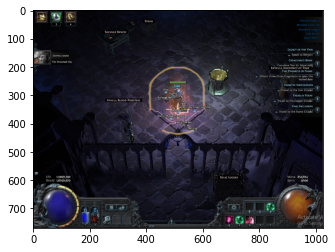

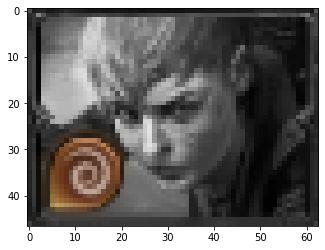

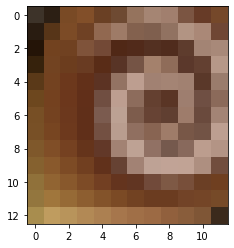

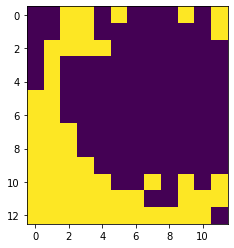

57

In [41]:
import matplotlib.pyplot as plt

print('poe_bot._generateColorfulImage')
game_img = poe_bot.getImage()
print('game_img')
plt.imshow(game_img);plt.show()
party_leader_img = game_img[party_member_to_follow['sz'][2]:party_member_to_follow['sz'][3], party_member_to_follow['sz'][0]:party_member_to_follow['sz'][1]]
plt.imshow(party_leader_img);plt.show()
teleport_to_img = party_leader_img[30:43, 5:17]
plt.imshow(teleport_to_img);plt.show()
sorted_img = sortByHSV(teleport_to_img, 76, 118, 109, 116, 213, 196)
plt.imshow(sorted_img);plt.show()
len(sorted_img[sorted_img != 0])
can_teleport = len(sorted_img[sorted_img != 0]) > 30

[Controller] debug sending action=mouseSetCursorPosSmooth&x=813&y=452&mtm=-1&msm=1 at 1737593232.1814682
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=813&y=452&mtm=-1&msm=1 at 1737593232.350471
[Controller] debug sending action=mousePress&x=-1&y=-1&button=left at 1737593232.6074681
[Controller] debug recieved response for action=mousePress&x=-1&y=-1&button=left at 1737593232.6254692
[Controller] debug sending action=mouseSetCursorPosSmooth&x=813&y=452&mtm=-1&msm=1 at 1737593232.6254692
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=813&y=452&mtm=-1&msm=1 at 1737593232.6664727
[Controller] debug sending action=mouseRelease&button=left at 1737593232.6664727
[Controller] debug recieved response for action=mouseRelease&button=left at 1737593232.6674726


In [10]:
print('poe_bot._generateColorfulImage')
game_img = poe_bot.getImage()
print('game_img')
plt.imshow(game_img);plt.show()

poe_bot._generateColorfulImage
[Controller] debug sending action=getPartialScreen&x1=208&y1=57&x2=1232&y2=825& at 1737593116.790524
[Controller] data_size_raw b'\x00$\x15\xa8'
[Controller] data_size 2364840
game_img


NameError: name 'plt' is not defined

In [39]:
import pickle
f = open('./blue_drops.pickle', 'wb')
pickle.dump(teleport_to_img, f)
f.close()

In [12]:
party_member_to_follow

{'is_leader': True,
 'same_location': False,
 'ign': 'Cryptglimmer',
 'area_raw_name': 'Aggorat',
 'sz': None}